# Part1. 格式資料準備

# 準備 初始權重 for 訓練用

In [75]:
import os
if not os.path.exists("model_data/yolo_weights.h5"):
    # 下載 yolov3 的網路權重(.weights)，並且把權重轉換為 keras 能夠讀取的格式(.h5)
    print("Converting pretrained YOLOv3 weights for training")
    #把 YOLO weights 轉換為能夠提供給 keras 作為訓練新模型的初始權重,注意argument 要使用 -w 
    os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
    print("Pretrained weights exists")

Pretrained weights exists


# 準備 轉換成 YOLO 格式

In [89]:
classes = ["kangaroo","raccoon"]
annot_lists=[]
for classename in classes:
    my_source="dataset/%s/Annotations"%(classename)
    for dirpath, dirname, files in os.walk(my_source):
        for file in files:
            annot_lists.append("./"+dirpath+"/"+file)
#annot_lists[0].replace("Annotations","images") .replace("xml","jpg")  

In [90]:
if not os.path.exists("K&C_train1.txt"): # 範例中訓練模型時所使用的，已經做好轉換的 annotation 檔名，增加這個檢查避免每次重新跑這段轉換的程式碼
    import xml.etree.ElementTree as ET # 載入能夠 Parser xml 文件的 library
    from os import getcwd

    # 資料類別
    classes = ["kangaroo","raccoon"]

    # 把 annotation 轉換訓練時需要的資料形態
    def convert_annotation(classname, image_id, list_file):
        in_file = open('dataset/%s/Annotations/%s.xml'%(classname, image_id))
        tree=ET.parse(in_file)
        root = tree.getroot()

        for obj in root.iter('object'):
          difficult = obj.find('difficult').text
          cls = obj.find('name').text
          if cls not in classes or int(difficult)==1:
              continue
          cls_id = classes.index(cls)
          xmlbox = obj.find('bndbox')
          b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
          list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

    annotation_path='K&C_train.txt'
    list_file = open(annotation_path, 'w')
    print("save annotation at %s" % annotation_path)
    for i in range(len(annot_lists)):
        list_file.write(annot_lists[i].replace("Annotations","images").replace("xml","jpg") )
        image_id=annot_lists[i].split('/')[-1].split('.xml')[0]
        classname=annot_lists[i].split('/')[2]
        convert_annotation(classname,image_id, list_file)
        list_file.write('\n')
    list_file.close()


save annotation at K&C_train.txt


# Part2. 載入model

In [95]:
import tensorflow as tf
print(tf.__version__)

1.13.1


In [96]:
# 將 train.py 所需要的套件載入
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [97]:
from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

In [98]:
annotation_path = 'K&C_train.txt' # 轉換好格式的標註檔案
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'model_data/K&C_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

# Step1. 先 freeze all layer  except output layer

In [99]:
input_shape = (416,416) # multiple of 32, hw

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 16
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=50,
            initial_epoch=0,
            callbacks=[logging, checkpoint])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

Create YOLOv3 model with 9 anchors and 2 classes.
Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.


ImportError: You need the TensorFlow module installed to use TensorBoard.

# Step2. 解除其他layer 改為可train

In [ ]:
input_shape = (416,416) # multiple of 32, hw
weights_path=log_dir + 'trained_weights_stage_1.h5'
model = create_model(input_shape, anchors, num_classes, weights_path=weights_path)

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    weights_path=log_dir + 'trained_tiny_weights_stage_1.h5'
    model = create_tiny_model(input_shape, anchors, num_classes,weights_path=weights_path)
else:
    weights_path=log_dir + 'trained_weights_stage_1.h5'
    model = create_model(input_shape, anchors, num_classes, weights_path=weights_path)

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 2 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=100,
        initial_epoch=50,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')

# Part3.  使用model 執行Detection

In [107]:
from yolo import YOLO

annotation_path = 'K&C_train.txt' # 轉換好格式的標註檔案
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'model_data/K&C_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'

yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)

In [113]:
from PIL import Image
image = Image.open('kangaroom-raccoon-img2.jpg') 

(416, 416, 3)
Found 2 boxes for img
Raccoon 0.96 (308, 44) (1024, 759)
Kangaroo 0.99 (0, 132) (432, 727)
4.2338538999902084


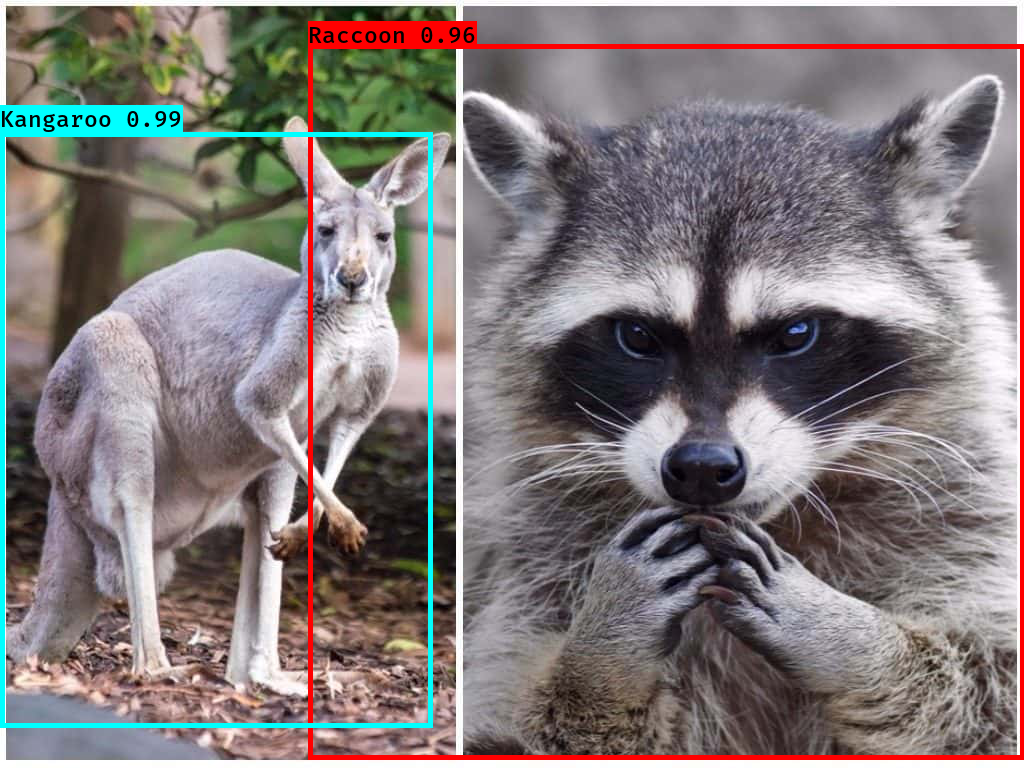

In [114]:
r_image = yolo_model.detect_image(image)
r_image

# Part4. Video

In [2]:
from yolo import YOLO,detect_video

Using TensorFlow backend.


In [5]:
annotation_path = 'K&C_train.txt' # 轉換好格式的標註檔案
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
CLASSES = 'model_data/K&C_classes.txt'
ANCHORS = 'model_data/yolo_anchors.txt'
MODEL=log_dir + 'trained_weights_final.h5'
video_input='Kangaroo.mp4'
video_output='Kangaroo-YOLO.mp4'

In [6]:
yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=CLASSES)

Instructions for updating:
Colocations handled automatically by placer.
logs/000/trained_weights_final.h5 model, anchors, and classes loaded.


In [ ]:
detect_video(yolo_model,video_path=video_input,output_path=video_output)

!!! TYPE: <class 'str'> <class 'int'> <class 'float'> <class 'tuple'>
(416, 416, 3)
Found 1 boxes for img
Raccoon 0.65 (322, 0) (1280, 720)
5.754354700000022
(416, 416, 3)
Found 1 boxes for img
Raccoon 0.65 (322, 0) (1280, 720)
1.58435750000001
(416, 416, 3)
Found 1 boxes for img
Raccoon 0.50 (335, 0) (1280, 720)
1.5952345000000037
(416, 416, 3)
Found 1 boxes for img
Raccoon 0.45 (323, 0) (1280, 720)
1.6057741999999848
(416, 416, 3)
Found 0 boxes for img
3.313726299999985
(416, 416, 3)
Found 0 boxes for img
3.470291099999997
(416, 416, 3)
Found 0 boxes for img
3.4734599999999887
(416, 416, 3)
Found 0 boxes for img
3.4478606999999784
(416, 416, 3)
Found 0 boxes for img
3.418822900000009
(416, 416, 3)
Found 0 boxes for img
3.4666004000000044
(416, 416, 3)
Found 0 boxes for img
3.4678223999999886
(416, 416, 3)
Found 0 boxes for img
3.433042499999999
(416, 416, 3)
Found 0 boxes for img
3.465432099999987
(416, 416, 3)
Found 0 boxes for img
3.4361549000000196
(416, 416, 3)
Found 0 boxes for 

Found 1 boxes for img
Kangaroo 0.46 (729, 398) (908, 675)
3.775281599999971
(416, 416, 3)
Found 1 boxes for img
Kangaroo 0.49 (733, 400) (903, 673)
3.7041163000000097
(416, 416, 3)
Found 1 boxes for img
Kangaroo 0.51 (732, 405) (902, 668)
3.592429399999901
(416, 416, 3)
Found 2 boxes for img
Kangaroo 0.43 (312, 125) (582, 584)
Kangaroo 0.49 (731, 407) (903, 666)
3.5680448000000524
(416, 416, 3)
Found 2 boxes for img
Kangaroo 0.43 (312, 125) (582, 584)
Kangaroo 0.49 (731, 407) (903, 666)
3.338811600000099
(416, 416, 3)
Found 2 boxes for img
Kangaroo 0.46 (729, 409) (903, 663)
Kangaroo 0.47 (313, 124) (584, 584)
4.663782900000001
(416, 416, 3)
Found 2 boxes for img
Kangaroo 0.47 (730, 408) (903, 663)
Kangaroo 0.49 (321, 129) (590, 579)
3.6508689999999433
(416, 416, 3)
Found 2 boxes for img
Kangaroo 0.46 (318, 136) (589, 579)
Kangaroo 0.47 (731, 408) (904, 663)
3.3813563999999587
(416, 416, 3)
Found 1 boxes for img
Kangaroo 0.93 (466, 0) (1068, 678)
2.499678200000062
(416, 416, 3)
Found 1

Found 1 boxes for img
Kangaroo 0.53 (0, 49) (1151, 610)
1.8697669999999107
(416, 416, 3)
Found 1 boxes for img
Kangaroo 0.56 (0, 50) (1151, 610)
1.8806277999999566
(416, 416, 3)
Found 1 boxes for img
Kangaroo 0.77 (0, 15) (1183, 639)
1.8460760000000391
(416, 416, 3)
Found 1 boxes for img
Kangaroo 0.69 (0, 20) (1230, 632)
1.8136610999999903
(416, 416, 3)
Found 1 boxes for img
Kangaroo 0.78 (0, 0) (1252, 661)
1.826348199999984
(416, 416, 3)
Found 1 boxes for img
Kangaroo 0.83 (0, 0) (1215, 596)
1.82592580000005
(416, 416, 3)
Found 1 boxes for img
Kangaroo 0.83 (0, 0) (1224, 593)
1.8192050000000108
(416, 416, 3)
Found 1 boxes for img
Kangaroo 0.87 (0, 0) (1218, 595)
1.8151202999999896
(416, 416, 3)
Found 2 boxes for img
Raccoon 0.34 (0, 10) (1280, 647)
Kangaroo 0.69 (0, 0) (1225, 590)
1.8194180000000415
(416, 416, 3)
Found 1 boxes for img
Kangaroo 0.60 (0, 0) (1235, 593)
1.8125456000000213
(416, 416, 3)
Found 1 boxes for img
Kangaroo 0.41 (0, 33) (1256, 625)
1.803570099999888
(416, 416, 3

Found 3 boxes for img
Kangaroo 0.35 (671, 413) (960, 683)
Kangaroo 0.62 (808, 259) (1060, 468)
Kangaroo 0.71 (99, 41) (322, 442)
1.8863248000000112
(416, 416, 3)
Found 3 boxes for img
Kangaroo 0.36 (671, 411) (961, 684)
Kangaroo 0.60 (808, 257) (1060, 469)
Kangaroo 0.72 (98, 41) (324, 444)
1.8573139999998602
(416, 416, 3)
Found 3 boxes for img
Kangaroo 0.39 (669, 415) (964, 680)
Kangaroo 0.63 (811, 258) (1056, 466)
Kangaroo 0.76 (99, 35) (324, 448)
1.8671345000000201
(416, 416, 3)
Found 2 boxes for img
Kangaroo 0.64 (814, 258) (1063, 463)
Kangaroo 0.75 (97, 31) (327, 449)
1.8484526000002006
(416, 416, 3)
Found 2 boxes for img
Kangaroo 0.65 (817, 260) (1067, 460)
Kangaroo 0.75 (97, 26) (329, 455)
1.8235006999998404
(416, 416, 3)
Found 2 boxes for img
Kangaroo 0.76 (97, 17) (332, 468)
Kangaroo 0.77 (809, 251) (1068, 467)
1.8460964000000786
(416, 416, 3)
Found 2 boxes for img
Kangaroo 0.77 (98, 16) (331, 469)
Kangaroo 0.77 (809, 251) (1068, 467)
1.8483949999999822
(416, 416, 3)
Found 2 bo

Found 0 boxes for img
1.8503202000001693
(416, 416, 3)
Found 0 boxes for img
1.8248720999999932
(416, 416, 3)
Found 0 boxes for img
1.8263535999999476
(416, 416, 3)
Found 0 boxes for img
1.8528633999999329
(416, 416, 3)
Found 0 boxes for img
1.8425165999999535
(416, 416, 3)
Found 0 boxes for img
1.8748538999998345
(416, 416, 3)
Found 1 boxes for img
Kangaroo 0.38 (529, 364) (712, 497)
1.8905899000001227
(416, 416, 3)
Found 0 boxes for img
1.8624096000000918
(416, 416, 3)
Found 0 boxes for img
1.865314200000057
(416, 416, 3)
Found 0 boxes for img
1.8732371999999486
(416, 416, 3)
Found 0 boxes for img
1.8513204999999289
(416, 416, 3)
Found 0 boxes for img
1.8451030000001083
(416, 416, 3)
Found 2 boxes for img
Kangaroo 0.37 (1003, 442) (1186, 538)
Kangaroo 0.48 (612, 353) (821, 494)
1.8678754999998546
(416, 416, 3)
Found 2 boxes for img
Kangaroo 0.33 (1005, 440) (1184, 537)
Kangaroo 0.40 (608, 350) (825, 497)
1.894964100000152
(416, 416, 3)
Found 1 boxes for img
Kangaroo 0.51 (1019, 435) 

Found 3 boxes for img
Kangaroo 0.40 (722, 218) (879, 470)
Kangaroo 0.44 (0, 118) (197, 440)
Kangaroo 0.59 (574, 407) (880, 694)
1.8891980999999305
(416, 416, 3)
Found 3 boxes for img
Kangaroo 0.40 (722, 218) (879, 470)
Kangaroo 0.44 (0, 118) (197, 441)
Kangaroo 0.59 (574, 407) (880, 694)
1.8763960000001134
(416, 416, 3)
Found 3 boxes for img
Kangaroo 0.40 (0, 120) (195, 436)
Kangaroo 0.42 (721, 222) (884, 466)
Kangaroo 0.63 (578, 408) (881, 694)
1.8743122999999287
(416, 416, 3)
Found 3 boxes for img
Kangaroo 0.35 (0, 108) (194, 443)
Kangaroo 0.40 (676, 240) (948, 489)
Kangaroo 0.61 (575, 413) (886, 688)
1.8768963999998505
(416, 416, 3)
Found 3 boxes for img
Kangaroo 0.37 (0, 103) (195, 442)
Kangaroo 0.49 (679, 241) (945, 489)
Kangaroo 0.63 (576, 417) (886, 686)
1.9807169000000613
(416, 416, 3)
Found 3 boxes for img
Kangaroo 0.36 (0, 113) (196, 436)
Kangaroo 0.43 (680, 239) (945, 485)
Kangaroo 0.60 (579, 421) (886, 688)
1.9387387000001581
(416, 416, 3)
Found 3 boxes for img
Kangaroo 0.3

Found 2 boxes for img
Kangaroo 0.31 (23, 0) (423, 720)
Kangaroo 0.97 (739, 29) (1105, 687)
1.897568400000182
(416, 416, 3)
Found 2 boxes for img
Kangaroo 0.35 (21, 0) (424, 720)
Kangaroo 0.96 (748, 35) (1088, 686)
1.898060100000066
(416, 416, 3)
Found 2 boxes for img
Kangaroo 0.35 (21, 0) (424, 720)
Kangaroo 0.96 (748, 36) (1089, 684)
1.88011019999999
(416, 416, 3)
Found 2 boxes for img
Kangaroo 0.35 (23, 0) (420, 720)
Kangaroo 0.95 (745, 31) (1088, 687)
1.8869658000000982
(416, 416, 3)
Found 2 boxes for img
Kangaroo 0.42 (19, 0) (420, 720)
Kangaroo 0.93 (746, 24) (1079, 695)
1.8530006000000867
(416, 416, 3)
Found 1 boxes for img
Kangaroo 0.94 (746, 23) (1076, 692)
1.883575300000075
(416, 416, 3)
Found 2 boxes for img
Kangaroo 0.49 (28, 0) (407, 720)
Kangaroo 0.95 (739, 19) (1081, 691)
1.9115984000000026
(416, 416, 3)
Found 2 boxes for img
Kangaroo 0.50 (28, 0) (407, 720)
Kangaroo 0.95 (739, 19) (1080, 693)
1.9146356999999625
(416, 416, 3)
Found 1 boxes for img
Kangaroo 0.95 (736, 18) 

Found 1 boxes for img
Kangaroo 0.95 (336, 291) (972, 657)
1.8914670999999998
(416, 416, 3)
Found 1 boxes for img
Kangaroo 0.95 (337, 292) (974, 657)
1.8896242000000711
(416, 416, 3)
Found 1 boxes for img
Kangaroo 0.98 (348, 275) (968, 685)
1.8939671999999064
(416, 416, 3)
Found 2 boxes for img
Kangaroo 0.54 (0, 265) (495, 607)
Kangaroo 0.91 (344, 248) (995, 720)
1.9047873999998046
(416, 416, 3)
Found 2 boxes for img
Kangaroo 0.75 (0, 217) (515, 660)
Kangaroo 0.96 (358, 298) (1077, 720)
1.878192399999989
(416, 416, 3)
Found 2 boxes for img
Kangaroo 0.79 (0, 230) (547, 551)
Kangaroo 0.95 (346, 316) (1110, 720)
1.8734053999999105
(416, 416, 3)
Found 2 boxes for img
Kangaroo 0.78 (0, 230) (546, 551)
Kangaroo 0.95 (347, 317) (1111, 720)
1.8908194999999068
(416, 416, 3)
Found 2 boxes for img
Kangaroo 0.75 (0, 235) (517, 546)
Kangaroo 0.86 (320, 334) (1155, 718)
1.8959389999999985
(416, 416, 3)
Found 2 boxes for img
Kangaroo 0.48 (0, 254) (457, 587)
Kangaroo 0.66 (320, 348) (1184, 711)
1.8971

Found 1 boxes for img
Kangaroo 0.70 (640, 127) (1004, 604)
1.9146155000000817
(416, 416, 3)
Found 1 boxes for img
Kangaroo 0.68 (640, 134) (1044, 604)
1.9038069999999152
(416, 416, 3)
Found 1 boxes for img
Kangaroo 0.71 (630, 131) (1042, 608)
1.9021692999999686
(416, 416, 3)
Found 1 boxes for img
Kangaroo 0.71 (630, 131) (1042, 608)
1.928627600000027
(416, 416, 3)
Found 1 boxes for img
Kangaroo 0.75 (629, 130) (1005, 595)
1.9003443000001425
(416, 416, 3)
Found 1 boxes for img
Kangaroo 0.66 (627, 137) (1002, 593)
1.900724500000024
(416, 416, 3)
Found 1 boxes for img
Kangaroo 0.65 (480, 144) (1014, 584)
1.902583199999981
(416, 416, 3)
Found 1 boxes for img
Kangaroo 0.61 (626, 126) (1029, 617)
1.891819299999952
(416, 416, 3)
Found 1 boxes for img
Kangaroo 0.61 (626, 126) (1029, 617)
1.8897028999999748
(416, 416, 3)
Found 1 boxes for img
Kangaroo 0.52 (634, 125) (1025, 619)
1.8847243000000162
(416, 416, 3)
Found 1 boxes for img
Kangaroo 0.58 (628, 130) (1026, 611)
1.9805390000001353
(416, 

Found 1 boxes for img
Raccoon 0.94 (0, 0) (1280, 720)
1.8440057000002525
(416, 416, 3)
Found 2 boxes for img
Raccoon 0.90 (0, 0) (1280, 720)
Kangaroo 0.31 (0, 0) (1280, 669)
1.9122814000002109
(416, 416, 3)
Found 1 boxes for img
Raccoon 0.93 (0, 0) (1280, 720)
1.8395672000001468
(416, 416, 3)
Found 2 boxes for img
Raccoon 0.88 (0, 0) (1280, 720)
Kangaroo 0.33 (0, 0) (1280, 675)
1.9334536000001208
(416, 416, 3)
Found 1 boxes for img
Raccoon 0.91 (0, 0) (1280, 720)
1.845288900000014
(416, 416, 3)
Found 2 boxes for img
Raccoon 0.79 (0, 0) (1280, 720)
Kangaroo 0.33 (0, 0) (1280, 642)
1.8382818999998563
(416, 416, 3)
Found 1 boxes for img
Raccoon 0.80 (0, 0) (1280, 720)
1.9285363999997571
(416, 416, 3)
Found 1 boxes for img
Raccoon 0.83 (0, 0) (1280, 720)
1.8924753000001147
(416, 416, 3)
Found 2 boxes for img
Raccoon 0.73 (0, 0) (1238, 720)
Kangaroo 0.31 (0, 0) (1280, 662)
1.9219323000002078
(416, 416, 3)
Found 1 boxes for img
Raccoon 0.70 (0, 0) (1280, 720)
1.9122984000000542
(416, 416, 3)

Found 1 boxes for img
Raccoon 0.90 (0, 0) (1247, 704)
1.8243615999999747
(416, 416, 3)
Found 1 boxes for img
Raccoon 0.84 (0, 0) (1280, 710)
1.8361777999998594
(416, 416, 3)
Found 1 boxes for img
Raccoon 0.83 (0, 0) (1280, 710)
1.823922500000208
(416, 416, 3)
Found 1 boxes for img
Raccoon 0.81 (0, 0) (1280, 716)
1.8341012000000774
(416, 416, 3)
Found 2 boxes for img
Raccoon 0.63 (0, 0) (1244, 718)
Kangaroo 0.43 (0, 0) (1280, 720)
1.8217775999996775
(416, 416, 3)
Found 2 boxes for img
Raccoon 0.50 (0, 0) (1280, 720)
Kangaroo 0.40 (0, 0) (1280, 720)
1.8149686000001566
(416, 416, 3)
Found 2 boxes for img
Raccoon 0.52 (0, 0) (1193, 720)
Kangaroo 0.39 (0, 0) (1280, 720)
1.8289884000000711
(416, 416, 3)
Found 2 boxes for img
Raccoon 0.54 (0, 0) (1280, 720)
Kangaroo 0.38 (0, 0) (1280, 720)
1.8808235999999852
(416, 416, 3)
Found 1 boxes for img
Raccoon 0.73 (0, 0) (1280, 720)
1.8269288999999844
(416, 416, 3)
Found 1 boxes for img
Raccoon 0.89 (0, 0) (1280, 720)
1.8153800999998566
(416, 416, 3)

Found 1 boxes for img
Raccoon 0.78 (0, 0) (1280, 711)
1.8386120999998639
(416, 416, 3)
Found 1 boxes for img
Raccoon 0.86 (0, 4) (1280, 683)
1.8359709999999723
(416, 416, 3)
Found 1 boxes for img
Raccoon 0.86 (0, 4) (1280, 683)
1.8557655999998133
(416, 416, 3)
Found 1 boxes for img
Raccoon 0.62 (0, 5) (1280, 677)
1.8713057999998455
(416, 416, 3)
Found 1 boxes for img
Raccoon 0.54 (0, 49) (1280, 627)
1.8435487000001558
(416, 416, 3)
Found 1 boxes for img
Raccoon 0.52 (0, 44) (1280, 626)
1.8451359999999113
(416, 416, 3)
Found 1 boxes for img
Raccoon 0.75 (0, 30) (1280, 641)
1.8293214999998781
(416, 416, 3)
Found 1 boxes for img
Raccoon 0.75 (0, 30) (1280, 643)
1.8098431000003075
(416, 416, 3)
Found 1 boxes for img
Raccoon 0.74 (0, 30) (1280, 648)
1.8353131999997458
(416, 416, 3)
Found 1 boxes for img
Raccoon 0.66 (0, 35) (1280, 650)
1.9293523999999707
(416, 416, 3)
Found 2 boxes for img
Raccoon 0.49 (0, 29) (1280, 645)
Kangaroo 0.51 (0, 8) (1280, 558)
2.038839399999688
(416, 416, 3)
Foun

Found 1 boxes for img
Kangaroo 0.67 (861, 354) (942, 615)
1.8623649999999543
(416, 416, 3)
Found 0 boxes for img
1.9525903999997354
(416, 416, 3)
Found 0 boxes for img
1.88567809999995
(416, 416, 3)
Found 0 boxes for img
1.8577264999998988
(416, 416, 3)
Found 1 boxes for img
Kangaroo 0.70 (821, 426) (936, 610)
1.812295400000039
(416, 416, 3)
Found 2 boxes for img
Kangaroo 0.34 (620, 367) (709, 569)
Kangaroo 0.55 (823, 413) (929, 617)
2.0793140000000676
(416, 416, 3)
Found 1 boxes for img
Kangaroo 0.69 (818, 431) (908, 635)
2.0934942000003502
(416, 416, 3)
Found 1 boxes for img
Kangaroo 0.69 (818, 432) (909, 634)
2.048657599999842
(416, 416, 3)
Found 1 boxes for img
Kangaroo 0.55 (800, 469) (899, 662)
2.036930199999915
(416, 416, 3)
Found 2 boxes for img
Kangaroo 0.31 (877, 337) (934, 533)
Kangaroo 0.43 (769, 514) (899, 630)
1.9253868000000693
(416, 416, 3)
Found 1 boxes for img
Kangaroo 0.41 (773, 499) (894, 640)
1.8898148000002948
(416, 416, 3)
Found 1 boxes for img
Kangaroo 0.80 (775